# Train YOLOv2 on LISA Dataset
-----------------------------------------------


In [1]:
import sys
print(sys.version) # Check Python Version
import numpy as np
import os
from keras.optimizers import Adam
from utils.parse_input import load_data    # Data handler for LISA dataset
from cfg import *

2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using TensorFlow backend.


### Prepare LISA Dataset

In [2]:
lisa_path = "/home/ubuntu/dataset/training/" # Remember the `/` at the end
pretrained_path = "/home/ubuntu/dataset/darknet19_544.weights"


x_train, y_train = load_data('training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)            # Count number of classes in the dataset
print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))
print("\nLabel Sample: \n{}".format(y_train[0]))

ANCHORS       = np.array(((0.023717899133663362, 0.035715759075907606),
(0.059577141608391594, 0.08738709207459215),
(0.08816276658767774, 0.1294924960505529),
(0.03283318210930825, 0.0483890193566751),
(0.04450034340659346, 0.064308608058608)))
print("\n\nRelative Anchors using K-mean clustering [K=5]\n {}".format(ANCHORS))

Number of ground truth boxes: 3672 boxes
Train: 3672 samples
Number of classes: 31

Label Sample: 
[1093.5 408.0 45.0 48.0 'doNotEnter']


Relative Anchors using K-mean clustering [K=5]
 [[ 0.0237179   0.03571576]
 [ 0.05957714  0.08738709]
 [ 0.08816277  0.1294925 ]
 [ 0.03283318  0.04838902]
 [ 0.04450034  0.06430861]]


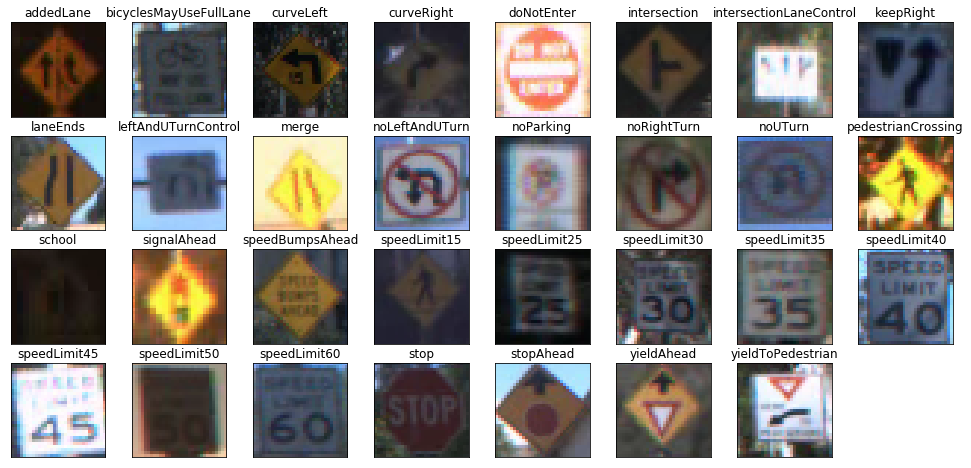

In [3]:
import cv2
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

def extract_sign(img, bbox, output_size=(32, 32)):
    xc, yc, w, h = bbox.x, bbox.y, bbox.w, bbox.h
    x1   = int(xc - w/2)
    y1   = int(yc - h/2)
    x2   = int(xc + w/2)
    y2   = int(yc + h/2)
    roi = img[y1:y2, x1:x2]
    roi = cv2.resize(roi, output_size)
    return roi
x_train, y_train = shuffle(x_train, y_train)
fig = plt.figure(figsize=(17, 8))
for i, label in enumerate(labels):
    ax           = fig.add_subplot(4, 8, 1 + i, xticks=[], yticks=[])
    idx          = np.where(y_train[:, 1] == label)[0][0]
    img          = cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB)
    box          = y_train[idx][0]
    sign_only    = extract_sign(img, box, (32, 32)) #  just extract the sign
    ax.set_title(label)
    plt.imshow(sign_only)
plt.show()

### Construct YOLOv2 On Keras

In [4]:
from yolov2.model import YOLOv2, darknet19
import keras.backend as K

K.clear_session() # Avoid duplicate model

darknet19 = darknet19(pretrained_path, freeze_layers=True)
yolov2    = YOLOv2(feature_extractor=darknet19, num_anchors=len(ANCHORS), num_classes=N_CLASSES)
model     = yolov2.model

Pre-trained weights have been loaded into model


In [5]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
import keras.backend as K
import tensorflow as tf

def custom_loss(y_true, y_pred):
    
    pred_shape = K.shape(y_pred)[1:3]
    
    GRID_W = tf.cast(pred_shape[0], tf.float32)
    GRID_H = tf.cast(pred_shape[1], tf.float32)
    
    NORM_W = tf.cast(32.*GRID_W, tf.float32)
    NORM_H = tf.cast(32.*GRID_H, tf.float32)
    
    no_object_scale = 0.5
    object_scale     = 5.0
    coordinate_scale = 1.0
    class_scale      = 1.0
    N_ANCHORS        = len(ANCHORS)

    pred_shape = K.shape(y_pred)[1:3]
    y_pred = K.reshape(y_pred, [-1, pred_shape[0], pred_shape[1], N_ANCHORS, N_CLASSES + 5])
    y_true = K.reshape(y_true, [-1, pred_shape[0], pred_shape[1], N_ANCHORS, N_CLASSES + 5])

    anchor_tensor = np.reshape(ANCHORS, [1, 1, 1, N_ANCHORS, 2])

    #  Adjust Prediction
    pred_box_xy   = tf.sigmoid(y_pred[:, :, :, :, :2])
    pred_box_wh   = tf.exp(y_pred[:, :, :, :, 2:4]) * anchor_tensor
    pred_box_wh   = tf.sqrt(pred_box_wh / K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2]))
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)  # adjust confidence
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])  # adjust probability

    #  Adjust ground truth
    center_xy = y_true[:, :, :, :, 0:2]
    center_xy = center_xy / K.reshape([(NORM_W / GRID_W), (NORM_H / GRID_H)], [1, 1, 1, 1, 2])

    true_box_xy = center_xy - tf.floor(center_xy)
    true_box_wh = y_true[:, :, :, :, 2:4]
    true_box_wh = tf.sqrt(true_box_wh / K.reshape([NORM_W, NORM_H], [1, 1, 1, 1, 2]))

    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2])
    pred_box_area = pred_tem_wh[:, :, :, :, 0] * pred_tem_wh[:, :, :, :, 1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh

    true_tem_wh = tf.pow(true_box_wh, 2) * K.reshape([GRID_W, GRID_H], [1, 1, 1, 1, 2])
    true_box_area = true_tem_wh[:, :, :, :, 0] * true_tem_wh[:, :, :, :, 1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh

    # Calculate IoU between ground truth and prediction
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul)
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:, :, :, :, 0] * intersect_wh[:, :, :, :, 1]

    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True))
    best_box = tf.to_float(best_box)
    # calculate avg_iou here

    true_box_conf = tf.expand_dims(best_box * y_true[:, :, :, :, 4], -1)
    true_box_prob = y_true[:, :, :, :, 5:]  # adjust confidence

    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)

    # Compute the weights

    # Object Confidence Loss
    weight_conf = no_object_scale * (1. - true_box_conf) + object_scale * true_box_conf

    # Object Localization Loss
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = coordinate_scale * weight_coor

    # Object Classification Loss
    weight_prob = tf.concat(N_CLASSES * [true_box_conf], 4)
    weight_prob = class_scale * weight_prob

    # Total Loss
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)

    # ## Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, tf.cast(GRID_W * GRID_H * N_ANCHORS * (4 + 1 + N_CLASSES), tf.int32)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)

    return loss


In [ ]:
import os
import keras
import keras
from utils.data_generator import flow_from_list
from sklearn.model_selection import train_test_split
from utils.multi_gpu import make_parallel, get_gpus

# HYPER-PARAMETERS
BATCH_SIZE = 8
EPOCHS     = 5
LEARN_RATE = 1e-6


# Data Generator
train_data_gen = flow_from_list(x_train, y_train, ANCHORS, batch_size=BATCH_SIZE, augment_data=False)

# For Debugging purpose
tf_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
check_pt = keras.callbacks.ModelCheckpoint('models/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                           verbose=0, save_best_only=False, 
                                           save_weights_only=False, mode='auto', period=1)

# TRAIN ON MULTI-GPUS
n_gpus = get_gpus()
if n_gpus > 1:
    BATCH_SIZE = n_gpus * BATCH_SIZE
    model = make_parallel(model, n_gpus)

model.compile(optimizer=Adam(LEARN_RATE),loss=custom_loss)
hist =  model.fit_generator(generator       = train_data_gen, 
                            steps_per_epoch = len(x_train) / BATCH_SIZE, 
                            epochs          = EPOCHS, 
                            callbacks       = [tf_board, check_pt],
                            workers=1, verbose=1)

model.save_weights('yolov2.weights')

Epoch 1/5
 25/459 [>.............................] - ETA: 1269s - loss: 381.2984

## Multi-GPUs Training - Data Parallelism Approach

* Each GPU will have a copy of the model
* During training time, mean of all gradidents from each GPU will be calculated to update the model
<img style="width:40%" src="https://www.tensorflow.org/images/Parallelism.png">

### Visualize training process using Tensorboard
Open `http://<public-dns>:6006`

In [ ]:
# import cv2
# import pandas as pd
# import numpy as np
# from sklearn.utils import shuffle
# import matplotlib.pyplot as plt
# %matplotlib inline

# def extract_sign(img, bbox, output_size=(32, 32)):
#     xc, yc, w, h = bbox.x, bbox.y, bbox.w, bbox.h
#     x1   = int(xc - w/2)
#     y1   = int(yc - h/2)
#     x2   = int(xc + w/2)
#     y2   = int(yc + h/2)
#     roi = img[y1:y2, x1:x2]
#     roi = cv2.resize(roi, output_size)
#     return roi
# x_train, y_train = shuffle(x_train, y_train)
# fig = plt.figure(figsize=(17, 8))
# for i, label in enumerate(labels):
#     ax           = fig.add_subplot(4, 8, 1 + i, xticks=[], yticks=[])
#     idx          = np.where(y_train[:, 1] == label)[0][0]
#     img          = cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB)
#     box          = y_train[idx][0]
#     sign_only    = extract_sign(img, box, (32, 32)) #  just extract the sign
#     ax.set_title(label)
#     plt.imshow(sign_only)
# plt.show()

In [ ]:
# ## Count frequencies of each traffic sign
# labels, frequencies = np.unique(y_train[:,1 ], return_counts=True)

# plt.figure(figsize=(20, 5))
# x = np.arange(len(labels))
# plt.xticks(x, labels, rotation=70)
# plt.bar(x, frequencies)